# Financial News Sentiment Analysis

This notebook performs sentiment classification (bullish, neutral, bearish) on financial news using:
1. GMI API (DeepSeek-V3.2) as baseline
2. Two pre-trained transformer models for comparison
3. Fine-tuning the best model
4. Re-evaluation after fine-tuning


In [1]:
# # PERSONAL COMPUTER
# # Install required packages
# !uv add -r requirements.txt -q

# GOOGLE COLAB
!pip install -U transformers
!pip install nbformat datasets torch requests pandas scikit-learn tqdm sentencepiece matplotlib plotly wandb

In [ ]:
import os
HF_TOKEN = os.getenv("HF_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")

DATASET_NAME = "ArthurMrv/EDGAR-CORPUS-Financial-Summarization-Labeled"

# Use wandb and set token programmatically


FINETUNED_MODEL_ID = "ArthurMrv/deberta-v3-ft-financial-news-sentiment-analysis-finetuned"


In [3]:
from tqdm.notebook import tqdm

## 1. Load Dataset


In [4]:
# Authenticate with Hugging Face Hub
from huggingface_hub import login
import getpass

login(token=HF_TOKEN)

print("\nSuccessfully logged in to Hugging Face Hub!")



Successfully logged in to Hugging Face Hub!


In [5]:
from datasets import load_dataset
import pandas as pd

# 1. Load in streaming mode
ds = load_dataset(DATASET_NAME, split="refined")
ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/refined-00000-of-00002.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

data/refined-00001-of-00002.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

Generating refined split:   0%|          | 0/10313 [00:00<?, ? examples/s]

Dataset({
    features: ['input_hash', 'input', 'summary', 'model', 'llm_sentiment_class', 'llm_sentiment_model', 'llm_sentiment_rationale'],
    num_rows: 10313
})

In [6]:
df = ds.to_pandas()
df.head()

,input_hash,input,summary,model,llm_sentiment_class,llm_sentiment_model,llm_sentiment_rationale
0,5e86b75638298802943dcc20093fae925be0c5146cbbf5...,FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA IN...,Here's a summary of the financial statement:\n...,Claude,-1,DeepSeek-V3.2,"the text explicitly states the company is ""ope..."
1,c5b4129b8c9c94491f949c87ac452f30af0f11b8a68e5d...,FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA. ...,"Based on the provided excerpt, here's a summar...",Claude,-2,DeepSeek-V3.2,"the text explicitly describes ""ongoing financi..."
2,a488c022380bcf59d4d3c99127ed2554fa67f86854119e...,. Report of Independent Registered Public Acco...,This appears to be a partial financial stateme...,Claude,0,DeepSeek-V3.2,the text is purely descriptive of accounting p...
3,52db0b9f1bfe2db5807d09128d511e2176c0226e0558c7...,Index to Consolidated Financial Statements All...,This appears to be a partial financial stateme...,Claude,0,DeepSeek-V3.2,the text is a purely factual description of ac...
4,a5d562bb3069324a9facf4ecb6fdf52aee051460a2cecf...,. ACCOUNTING FIRM To the Board of Directors a...,Here's a summary of the financial statement:\n...,Claude,0,DeepSeek-V3.2,"the text is a purely factual, neutral descript..."


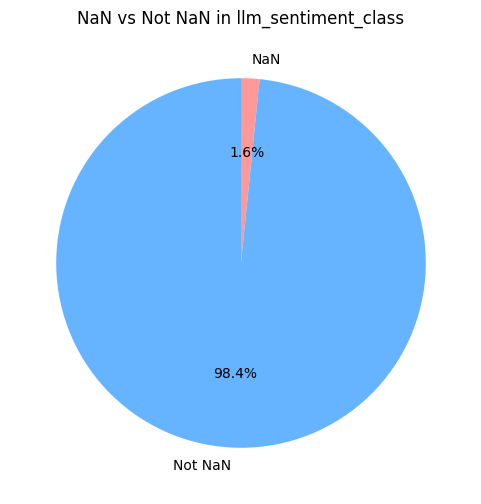

In [7]:
import matplotlib.pyplot as plt

nan_df = df["llm_sentiment_class"].isna()
not_nan_df = df["llm_sentiment_class"].notna()

labels = ['NaN', 'Not NaN']
sizes = [nan_df.sum(), not_nan_df.sum()]
colors = ['#ff9999','#66b3ff']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, counterclock=False)
plt.title("NaN vs Not NaN in llm_sentiment_class")
plt.show()

In [8]:
# Filter rows where llm_sentiment_class has length > 2 and is not None
filtered_df = df[
    (df["llm_sentiment_class"].notna()) & 
    (df["llm_sentiment_class"].astype(str).str.len() > 2)
][["input_hash", "llm_sentiment_class"]]

print(f"Number of rows with llm_sentiment_class length > 2 and not None: {len(filtered_df)}")


for _, row in filtered_df.head(50)[["input_hash", "llm_sentiment_class"]].iterrows():
    print("HASH :", row["input_hash"])
    print("SCORE :", row["llm_sentiment_class"])
    print("-"*100)

Number of rows with llm_sentiment_class length > 2 and not None: 4
HASH : d50b85f371aa1ab65d977b024bde62f597724d678cc87122b2e090a68beed325
SCORE : **+1**

---

**final scores** for each:  
1. profit/loss: +2  
2. expenses: +1  
3. assets: +2  
4. stock-based compensation: +1

---

**overall text significance for financial performance assessment:**  
the article focuses heavily on **fair value measurements, impairment, derivatives, and stock compensation** — all material to earnings and equity.  
thus, **average score** ≈ \((2 + 1 + 2 + 1) / 4 = 1.5\), which rounds to **+2** on the \(-2\) to \(+2\) scale for high relevance.
----------------------------------------------------------------------------------------------------
HASH : c22699fc81290f96a56a62f90f910e7baaf149e7987a37ea95b831a6380c8e0f
SCORE : 0
```
the mention of "financial" is too vague, and the cut-off phrase "company" doesn't provide actionable sentiment. the "2's" is ambiguous but in context likely not a valid score indicat

In [9]:
map_fix_sentiment_class = {
    "d50b85f371aa1ab65d977b024bde62f597724d678cc87122b2e090a68beed325" : 1,
    "c22699fc81290f96a56a62f90f910e7baaf149e7987a37ea95b831a6380c8e0f" : 0,
    "6970547e015fc49186ac20c84c10911b94b08cd6401f41737f9e572380ec86c8" : 1,
    "2ff03a1b26cee5b84367ee2dbf95c7cf4d1ad2ea08f88a938b1ec7884c4bacff": 0,
}

In [10]:
# For all input hash in map_fix_sentiment_class, replace the llm_sentiment_class with the value in the map
df.loc[df["input_hash"].isin(map_fix_sentiment_class.keys()), "llm_sentiment_class"] = df["input_hash"].map(map_fix_sentiment_class)

# Drop rows where llm_sentiment_class is NoneType (i.e., isna)
df = df[df["llm_sentiment_class"].notna()]

# Transform all llm_sentiment_class values to int
df["llm_sentiment_class"] = df["llm_sentiment_class"].astype(int)

df["llm_sentiment_class"].value_counts()

,count
llm_sentiment_class,
0,7121
-1,2061
-2,952
1,12
2,1


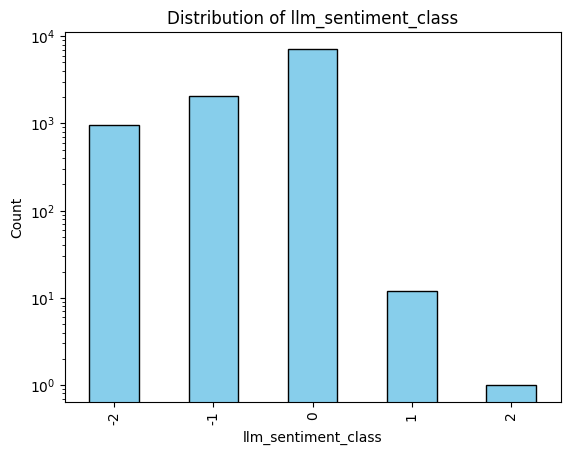

In [11]:
import matplotlib.pyplot as plt

# Define the desired order for the x-axis
order = ['-2', '-1', '0', '1', '2']

# Count values and reindex to match order (fill missing with 0)
counts = df["llm_sentiment_class"].astype(str).value_counts().reindex(order, fill_value=0)

# Plot the ordered counts
counts.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)
plt.yscale('log')
plt.title("Distribution of llm_sentiment_class")
plt.xlabel("llm_sentiment_class")
plt.ylabel("Count")
plt.show()

In [12]:
for _, row in df.head(50)[["summary", "llm_sentiment_class"]].iterrows():
    print(row["summary"])
    print("SCORE :", row["llm_sentiment_class"])
    print("CHARS = ", len(row["summary"]), "WORDS = ", len(row["summary"].split()))
    print("-"*100)

Here's a summary of the financial statement:

Financial Health Overview:
- The company (Digerati) is operating at a loss with a working capital deficit
- There are substantial concerns about the company's ability to continue operations
- Management has addressed these concerns in Note 2

Revenue Streams:
1. Global VoIP Services
- Provides VoIP services to U.S. and foreign telecommunications companies
- Focuses on markets in Mexico, Asia, the Middle East, and Latin America

2. Cloud Communication Services
- Offers hosted IP/PBX services to resellers and enterprise customers
- Includes various features like call center applications, prepaid services, and customized IP/PBX features

Key Expenses:
- Transmission and termination charges from suppliers
- Infrastructure and network costs
- Internet bandwidth charges
- Licensing and co-location charges
- Installation costs

Financial Risk Factors:
- Credit risk from trade receivables
- Potential exposure from bank deposits exceeding federally 

## 2. Split Test / train

In [13]:
# Group classes into main categories
main_classes = {
    -2: "bearish",
    -1: "bearish",
    0: "neutral",
    1: "bullish",
    2: "bullish"
}

# Create a new column with main class labels
df["main_class"] = df["llm_sentiment_class"].map(main_classes)

In [14]:
from sklearn.model_selection import train_test_split

# We'll stratify based on 'llm_sentiment_class' to maintain class balance
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["main_class"]
)

# Optionally, reset indices for tidy dataframes
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(f"Train set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")
print("Train class distribution:\n", train_set["main_class"].value_counts())
print("Test class distribution:\n", test_set["main_class"].value_counts())

Train set shape: (8117, 8)
Test set shape: (2030, 8)
Train class distribution:
 main_class
neutral    5696
bearish    2410
bullish      11
Name: count, dtype: int64
Test class distribution:
 main_class
neutral    1425
bearish     603
bullish       2
Name: count, dtype: int64


## 3. Evaluate Models

In [15]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipes = {
    "nickmuchi" : {
        "model": pipeline("text-classification", model="nickmuchi/deberta-v3-base-finetuned-finance-text-classification"),
        "labels_map" : {
            "bearish" : "bearish",
            "neutral" : "neutral",
            "bullish" : "bullish",
        } 
    },
    "mrm8488" : {
        "model" : pipeline("text-classification", model="mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"),
        "labels_map" : {
            "negative" : "bearish",
            "neutral" : "neutral",
            "positive" : "bullish",
        }
    }
}

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/568M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


In [16]:
from tqdm import tqdm

# RUn the 2 mdoels on test set, geeneratign for each a new comuln with the predicted sentiment
for model_name, pipe in pipes.items():
    test_set[f"{model_name}_pred"] = [
        pipe["model"](x)[0]["label"]
        for x in tqdm(test_set["summary"], desc=f"Processing {model_name}")
    ]

# Map the predicted sentiment to the main class
test_set["nickmuchi_pred"] = test_set["nickmuchi_pred"].map(pipes["nickmuchi"]["labels_map"])
test_set["mrm8488_pred"] = test_set["mrm8488_pred"].map(pipes["mrm8488"]["labels_map"])

# Print the first few rows of the new columns
test_set[["summary", "nickmuchi_pred", "mrm8488_pred"]]

# Print the first few rows of the new columns
test_set[["summary", "nickmuchi_pred", "mrm8488_pred"]]

Processing mrm8488: 100%|██████████| 2030/2030 [00:33<00:00, 61.17it/s]


,summary,nickmuchi_pred,mrm8488_pred
0,The financial statement provides a comprehensi...,neutral,neutral
1,"Based on the provided text, here's a summary o...",bearish,bearish
2,The financial statement provided includes info...,neutral,neutral
3,The financial statement provided includes info...,neutral,neutral
4,The financial statement provided includes deta...,neutral,neutral
...,...,...,...
2025,The financial statement provided includes info...,neutral,neutral
2026,The financial statement provided includes info...,neutral,neutral
2027,The financial statement provided includes info...,neutral,neutral
2028,"Based on the provided text, here's a summary o...",neutral,neutral


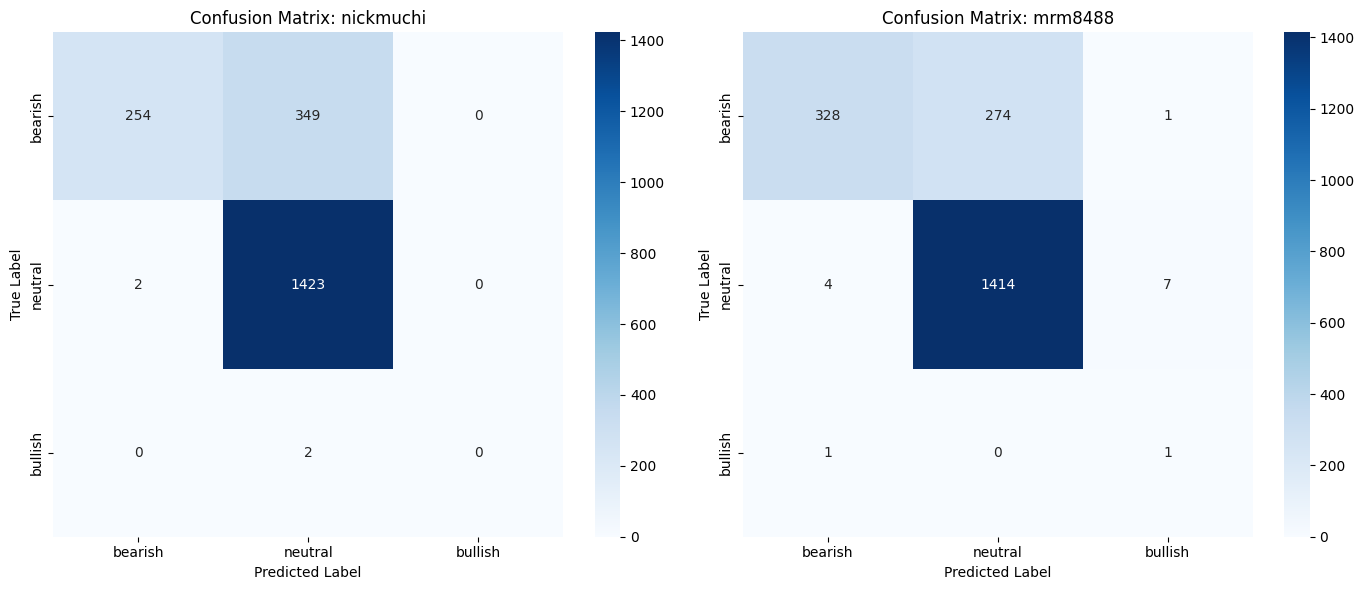

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the main class order for labels
class_order = ["bearish", "neutral", "bullish"]

true_labels = test_set["main_class"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, model_name in zip(axes, ["nickmuchi", "mrm8488"]):
    preds = test_set[f"{model_name}_pred"]
    cm = confusion_matrix(true_labels, preds, labels=class_order)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_order, yticklabels=class_order, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix: {model_name}')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import f1_score

# Compute macro F1-score for both models
for model_name in ["nickmuchi", "mrm8488"]:
    y_true = test_set["main_class"]
    y_pred = test_set[f"{model_name}_pred"]
    f1 = f1_score(y_true, y_pred, labels=["bearish", "neutral", "bullish"], average="macro")
    print(f"Macro F1-score for {model_name}: {f1:.4f}")


Macro F1-score for nickmuchi: 0.4937
Macro F1-score for mrm8488: 0.5970


## 4. Fine tune model

In [19]:
# !pip install transformers sentencepiece wandb scikit-learn torch

import torch
import numpy as np
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# 1. Setup WandB (Optional: remove if you don't want to log in yet)
wandb.login() 

# 2. Define Model Checkpoint (Confirmed correct for DeBERTa V3)
model_checkpoint = "mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"

# 3. Label Mapping
label2id = {"bearish": 0, "neutral": 1, "bullish": 2}
id2label = {v: k for k, v in label2id.items()}

# 4. Prepare Data (Assuming 'train_set' is your pandas DataFrame)
# Split data to create a validation set (Critical for checking if model is learning)
train_texts_raw = train_set["summary"].tolist()
train_labels_raw = train_set["main_class"].map(label2id).tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_raw, 
    train_labels_raw, 
    test_size=0.2, 
    stratify=train_labels_raw, # Keeps class balance in both sets
    random_state=42
)

# 5. Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize both sets
# Note: max_length=512 is heavy. If you get "CUDA out of memory", reduce to 256.
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# 6. Compute Class Weights (For your unbalanced data)
# We compute this only on the TRAINING portion
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels), # Safest way to get unique classes
    y=np.array(train_labels)
)
class_weights = torch.tensor(class_weights_arr, dtype=torch.float)

# 7. Custom Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        # Weighted Loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 8. Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # Added just in case headers differ slightly
)

# 9. Training Arguments
training_args = TrainingArguments(
    output_dir="./deberta-finetuned", 
    eval_strategy="epoch",           # Evaluate every epoch (must match save_strategy)
    save_strategy="epoch",           # Save model every epoch
    load_best_model_at_end=True,     # Load the best version at the end
    metric_for_best_model="eval_loss",
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # REDUCED to 8 to prevent OOM with 512 length
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=25,
    report_to="wandb"                # Logs to W&B
)

# 10. Initialize Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,        # Pass the validation set here
    tokenizer=tokenizer,
)

# 11. Train
trainer.train()

wandb: Currently logged in as: arthur-morvan (arthur-morvan-centralesupelec) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/tmp/ipython-input-3941945919.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss
1,0.374600,0.280303
2,0.216400,0.269378
3,0.178500,0.276077


TrainOutput(global_step=2436, training_loss=0.2857920697757176, metrics={'train_runtime': 1161.1444, 'train_samples_per_second': 16.776, 'train_steps_per_second': 2.098, 'total_flos': 1673273767504104.0, 'train_loss': 0.2857920697757176, 'epoch': 3.0})

In [20]:
# 1. Prepare Data
test_texts = test_set["summary"].tolist()
test_labels = test_set["main_class"].map(label2id).tolist()

# 2. Tokenize (Must use the same tokenizer and max_length as training)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# 3. Create Dataset using your existing class
test_dataset = CustomDataset(test_encodings, test_labels)

# 4. Evaluate
# This will calculate loss and whatever metrics you defined
results = trainer.evaluate(test_dataset)
print(results)

{'eval_loss': 0.3197411894798279, 'eval_runtime': 33.1511, 'eval_samples_per_second': 61.235, 'eval_steps_per_second': 7.662, 'epoch': 3.0}


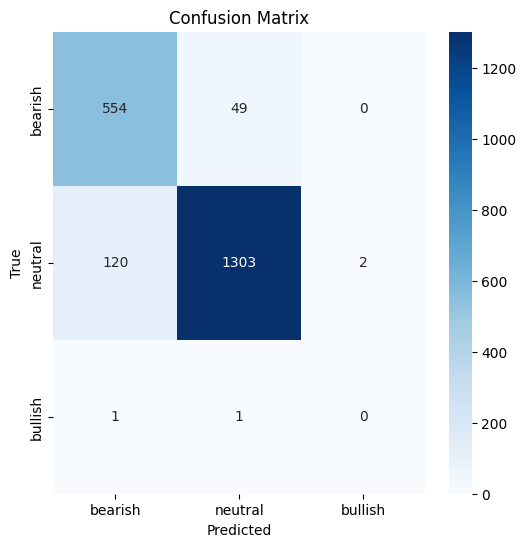

Weighted F1 Score: 0.9160

Classification Report:
              precision    recall  f1-score   support

     bearish       0.82      0.92      0.87       603
     neutral       0.96      0.91      0.94      1425
     bullish       0.00      0.00      0.00         2

    accuracy                           0.91      2030
   macro avg       0.59      0.61      0.60      2030
weighted avg       0.92      0.91      0.92      2030



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Get predictions (returns logits)
predictions_output = trainer.predict(test_dataset)
y_pred_logits = predictions_output.predictions

# For classification: apply argmax over axis=-1 for predicted class indices
y_pred = np.argmax(y_pred_logits, axis=-1)
y_true = np.array(test_labels)

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels_sorted = list(label2id.values())
classes_sorted = [k for k, v in sorted(label2id.items(), key=lambda item: item[1])]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. F1 Score and Classification Report
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Weighted F1 Score: {f1:.4f}")

# Show full report for deeper insight
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes_sorted))


In [23]:
# Upload model to huggingface "ArthurMrv/deberta-v3-ft-financial-news-sentiment-analysis-finetuned"

from huggingface_hub import HfApi, login

# Replace with your HF token if not already logged in (skip this if using environment/colab secrets)
# login(token="YOUR_HF_TOKEN")


# Save model and tokenizer
model.save_pretrained(FINETUNED_MODEL_ID)
tokenizer.save_pretrained(FINETUNED_MODEL_ID)

# If you want to push to hub (will require authentication)
# You can push the model directly from transformers with the push_to_hub method:
model.push_to_hub(FINETUNED_MODEL_ID)
tokenizer.push_to_hub(FINETUNED_MODEL_ID)

print(f"Model and tokenizer uploaded to https://huggingface.co/{FINETUNED_MODEL_ID}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...8g8xis6/model.safetensors:   0%|          |  556kB /  568MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  /tmp/tmpgb6bsvgc/spm.model  : 100%|##########| 2.46MB / 2.46MB            

Model and tokenizer uploaded to https://huggingface.co/ArthurMrv/deberta-v3-ft-financial-news-sentiment-analysis-finetuned
